## General network properties: Size, Degree

In [56]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import os
import config
import dataframe_image as dfi
from config import LEVELS, NETWORKS_PATH, DATA_REACTOME_PATH, PATHWAY_GRAPHS_PATH
from lib.networks import get_interactomes, get_combinations, get_combinations_with_pathways
from lib.networks import get_multiindex
from lib.networks import get_sizes

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

pathway_networks_path = PATHWAY_GRAPHS_PATH
if not Path(pathway_networks_path).exists():
    os.mkdir(pathway_networks_path)

interactome_networks_path = NETWORKS_PATH + "interactomes/"
if not Path(interactome_networks_path).exists():
    os.mkdir(interactome_networks_path)

config.set_root_wd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Initial working directory: C:\Users\luisp\OneDrive\Documents\phd\ProteoformNetworks\src\Python
New working directory: c:\Users\luisp\OneDrive\Documents\phd\ProteoformNetworks


In [57]:
# Create interactome networks and store them in the /networks/interactomes/ directory

interactomes_no_sm, interactomes_with_sm, interactomes_with_unique_sm = get_interactomes(config.DATA_REACTOME_PATH, interactome_networks_path)
interactomes = [*interactomes_no_sm.values(), *interactomes_with_sm.values(), *interactomes_with_unique_sm.values()]

Reading participants of all reactions for level genes...
Reading participants of all reactions for level proteins...
Reading participants of all reactions for level proteoforms...
Reading participants of all reactions for level sm...
Reading components of all complexes for level genes...
Reading components of all complexes for level proteins...
Reading components of all complexes for level proteoforms...
Reading components of all complexes for level sm...
Reading interaction network for  at genes level, method no_sm...
Reading interaction network for  at proteins level, method no_sm...
Reading interaction network for  at proteoforms level, method no_sm...
Reading interaction network for  at genes level, method with_sm...
Reading interaction network for  at proteins level, method with_sm...
Reading interaction network for  at proteoforms level, method with_sm...
Reading interaction network for  at genes level, method with_unique_sm...
Reading interaction network for  at proteins level, 

In [58]:
index = get_multiindex()
num_interactions, num_entities, num_small_molecules = get_sizes(interactomes, index)
num_interactions

Small Molecules           Entity Level
Not Included              genes            365068
                          proteins         374362
                          proteoforms      590204
Included                  genes            451221
                          proteins         461128
                          proteoforms      682711
Reaction-Unique Included  genes            808025
                          proteins         822205
                          proteoforms     1047807
dtype: int64

In [59]:
df_sizes = pd.DataFrame({
    "Interactions": num_interactions,
    "Accessioned Entities": num_entities,
    "Small Molecules": num_small_molecules
}, index=index)
df_sizes.columns.name = "Sizes"
dfi.export(df_sizes, 'figures/interactome_sizes.png')
df_sizes

Sizes                                  Interactions  Accessioned Entities  \
Small Molecules          Entity Level                                       
Not Included             genes               365068                 10966   
                         proteins            374362                 11064   
                         proteoforms         590204                 14340   
Included                 genes               451221                 10966   
                         proteins            461128                 11064   
                         proteoforms         682711                 14340   
Reaction-Unique Included genes               808025                 10966   
                         proteins            822205                 11064   
                         proteoforms        1047807                 14340   

Sizes                                  Small Molecules  
Small Molecules          Entity Level                   
Not Included             genes                       0  
                         proteins                    0  
                         proteoforms                 0  
Included                 genes                    2087  
                         proteins                 2087  
                         proteoforms              2087  
Reaction-Unique Included genes                   29561  
                         proteins                29561  
                         proteoforms             29561

In [60]:
# Create a list with the number of genes, proteins, proteoforms, small molecules
num_nodes = [*df_sizes.loc[['Not Included']]["Accessioned Entities"], df_sizes.loc[['Included']]["Small Molecules"][0]]

# Create list with all levels:
node_types = [*LEVELS, "small molecules"]

# Create a list with the number of interactions without the small molecules
num_interactions_no_sm = df_sizes.loc[['Not Included']]["Interactions"]

num_interactions_with_sm = df_sizes.loc[['Included']]["Interactions"]

maxy = max([*num_interactions_with_sm, *num_interactions_no_sm])

maxy = 800000

C:\Users\luisp\AppData\Local\Temp\ipykernel_24028\703382627.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot2.set_xticklabels(LEVELS, rotation=45)
C:\Users\luisp\AppData\Local\Temp\ipykernel_24028\703382627.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot3.set_xticklabels(LEVELS, rotation=45)


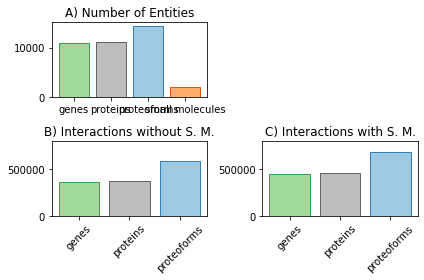

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from config import COLORS_BORDER

figure, axis = plt.subplots(1, 4)
# Placing the plots in the plane
plot1 = plt.subplot2grid((2, 2), (0, 0), rowspan=1, colspan=1)
plot2 = plt.subplot2grid((2, 2), (1, 0), rowspan=1, colspan=1)
plot3 = plt.subplot2grid((2, 2), (1, 1), rowspan=1, colspan=1)

# Plot number of nodes
plot1.bar(node_types, num_nodes, color=config.COLORS_FILL, edgecolor=COLORS_BORDER)
plot1.set_title('A) Number of Entities')

plt.xticks(rotation=90)

# Plot number of interactions without small molecules
plot2.bar(LEVELS, num_interactions_no_sm, color=config.COLORS_FILL, edgecolor=COLORS_BORDER)
plot2.set_title('B) Interactions without S. M.')
plot2.set_ylim([0, maxy])
plot2.set_xticklabels(LEVELS, rotation=45)

# Plot number of interactions with small molecules
plot3.bar(LEVELS, num_interactions_with_sm, color=config.COLORS_FILL, edgecolor=COLORS_BORDER)
plot3.set_title('C) Interactions with S. M.')
plot3.set_ylim([0, maxy])
plot3.set_xticklabels(LEVELS, rotation=45)

# Packing all the plots and displaying them
plt.tight_layout()
plt.show()

figure.savefig('figures/figure_4.png')
plt.close()

In [62]:
from lib.networks import get_increase_percentage
from config import genes, proteins, proteoforms

increase = get_increase_percentage(interactomes_no_sm[genes].number_of_nodes(),
                                   interactomes_no_sm[proteins].number_of_nodes())
print(f"There are {increase} % more nodes in the protein interactome than in the gene interactome.")

increase = get_increase_percentage(interactomes_no_sm[genes].number_of_edges(),
                                   interactomes_no_sm[proteins].number_of_edges())
print(f"There are {increase} % more interactions in the protein interactome than in the gene interactome.")

increase = get_increase_percentage(interactomes_no_sm[proteins].number_of_nodes(),
                                   interactomes_no_sm[proteoforms].number_of_nodes())
print(f"There are {increase} % more nodes in the proteoform interactome than in the protein interactome.")

increase = get_increase_percentage(interactomes_no_sm[proteins].number_of_edges(),
                                   interactomes_no_sm[proteoforms].number_of_edges())
print(f"There are {increase} % more interactions in the proteoform interactome than in the protein interactome.")

There are 0.89 % more nodes in the protein interactome than in the gene interactome.
There are 2.48 % more interactions in the protein interactome than in the gene interactome.
There are 22.85 % more nodes in the proteoform interactome than in the protein interactome.
There are 36.57 % more interactions in the proteoform interactome than in the protein interactome.


In [63]:
for l in LEVELS:
    increase_generic = get_increase_percentage(
        interactomes_no_sm[l].number_of_nodes(),
        interactomes_with_sm[l].number_of_nodes()
    )
    print(f"In the {l} network, there is an increase of {increase_generic} % more nodes when adding generic small molecules")
    increase_unique = get_increase_percentage(
        interactomes_no_sm[l].number_of_nodes(),
        interactomes_with_unique_sm[l].number_of_nodes()
    )
    print(f"In the {l} network, there is an increase of {increase_unique} % more nodes when adding reaction-unique small molecules")

increase_with_generic_sm = [get_increase_percentage(
        interactomes_no_sm[l].number_of_nodes(),
        interactomes_with_sm[l].number_of_nodes()
    ) for l in LEVELS]
percentage_generic_sm = [
    (interactomes_with_sm[l].number_of_nodes() - interactomes_no_sm[l].number_of_nodes()) / interactomes_with_sm[l].number_of_nodes()
    for l in LEVELS]
increase_with_unique_sm = [get_increase_percentage(
        interactomes_no_sm[l].number_of_nodes(),
        interactomes_with_unique_sm[l].number_of_nodes()
    ) for l in LEVELS]
percentage_unique_sm = [
    (interactomes_with_unique_sm[l].number_of_nodes() - interactomes_no_sm[l].number_of_nodes()) / interactomes_with_unique_sm[l].number_of_nodes()
    for l in LEVELS]

d = {
    "Increase of nodes with generic small molecules": increase_with_generic_sm,
    "Percentage of generic small molecule nodes": percentage_generic_sm,
    "Increase of nodes with unique small molecules": increase_with_unique_sm,
    "Percentage of unique small molecule nodes ": percentage_unique_sm
}

df_increase_sm = pd.DataFrame(data=d, index=LEVELS)
dfi.export(df_increase_sm, 'figures/interactome_size_increase.png')
df_increase_sm


In the genes network, there is an increase of 15.99 % more nodes when adding generic small molecules
In the genes network, there is an increase of 72.94 % more nodes when adding reaction-unique small molecules
In the proteins network, there is an increase of 15.87 % more nodes when adding generic small molecules
In the proteins network, there is an increase of 72.77 % more nodes when adding reaction-unique small molecules
In the proteoforms network, there is an increase of 12.7 % more nodes when adding generic small molecules
In the proteoforms network, there is an increase of 67.34 % more nodes when adding reaction-unique small molecules


,Increase of nodes with generic small molecules,Percentage of generic small molecule nodes,Increase of nodes with unique small molecules,Percentage of unique small molecule nodes
genes,15.99,0.16,72.94,0.73
proteins,15.87,0.16,72.77,0.73
proteoforms,12.70,0.13,67.34,0.67


In [64]:
from statistics import mean
from lib.dictionaries import read_dictionary_one_to_set

map_genes_to_proteins = read_dictionary_one_to_set(interactome_networks_path, "mapping_proteins_to_genes.tsv",
                                                   col_indices=(1, 0))
print(f"There are {len(map_genes_to_proteins.keys())} genes in the map.")

avg_proteins_per_gene = round(mean([len(map_genes_to_proteins[key]) for key in map_genes_to_proteins.keys()]), 2)
print(f"The average number of proteins per gene is {avg_proteins_per_gene}")

There are 10966 genes in the map.
The average number of proteins per gene is 1.01


In [65]:
map_proteins_to_proteoforms = read_dictionary_one_to_set(interactome_networks_path, "mapping_proteins_to_proteoforms.tsv",
                                                         col_indices=(0, 1))
print(f"There are {len(map_proteins_to_proteoforms.keys())} proteins in the map.")

avg_proteoforms_per_protein = round(
    mean([len(map_proteins_to_proteoforms[key]) for key in map_proteins_to_proteoforms.keys()]), 2)
print(f"The average number of proteoforms per protein is {avg_proteoforms_per_protein}")

There are 11064 proteins in the map.
The average number of proteoforms per protein is 1.3


# Degree

In [66]:
degree_sequences = []
for interactome in interactomes:
    accessioned_nodes = [node for node, data in interactome.nodes(data=True) if not data['type'].startswith("Simple")]
    sequence = sorted([d for n, d in interactome.degree(accessioned_nodes)], reverse=True)
    degree_sequences.append(sequence)

degree_sequences = pd.Series([sorted(sequence, reverse=True) for sequence in degree_sequences], index=index)
degree_sequences

Small Molecules           Entity Level
Not Included              genes           [1241, 1218, 1057, 1057, 586, 578, 540, 530, 5...
                          proteins        [1242, 1219, 1058, 1058, 594, 578, 542, 532, 5...
                          proteoforms     [1469, 1444, 1279, 1279, 627, 619, 606, 604, 6...
Included                  genes           [1293, 1270, 1106, 1106, 765, 754, 645, 642, 6...
                          proteins        [1294, 1271, 1107, 1107, 767, 756, 647, 642, 6...
                          proteoforms     [1520, 1495, 1327, 1327, 780, 762, 747, 720, 7...
Reaction-Unique Included  genes           [2361, 2331, 1989, 1809, 1769, 1559, 1559, 153...
                          proteins        [2363, 2333, 1991, 1810, 1770, 1560, 1560, 153...
                          proteoforms     [2376, 2339, 2029, 1997, 1987, 1773, 1773, 153...
dtype: object

In [67]:
i = interactomes_no_sm["genes"]
df = pd.DataFrame(data=list(i.degree()), columns=['Node', 'Degree'])
df.sort_values(by=['Degree'], inplace=True)
df

,Node,Degree
10965,EMILIN2,0
8620,KRTAP13-2,0
8619,KRTAP15-1,0
8618,KRTAP13-4,0
8617,KRTAP23-1,0
...,...,...
423,RAC1,586
54,UBB,1057
55,UBC,1057
57,UBA52,1218


In [68]:
print(f"(Genes, No SM) {interactomes_no_sm['genes'].degree['GPR35']}")
print(f"Neighbours: {[n for n in interactomes_no_sm['genes'].neighbors('GPR35')]}")
print(f"(Genes, With SM) {interactomes_with_sm['genes'].degree['GPR35']}")
print(f"Neighbours: {[n for n in interactomes_with_sm['genes'].neighbors('GPR35')]}")
print(f"(Genes, With Unique SM) {interactomes_with_unique_sm['genes'].degree['GPR35']}")
print(f"Neighbours: {[n for n in interactomes_with_unique_sm['genes'].neighbors('GPR35')]}")


(Genes, No SM) 0
Neighbours: []
(Genes, With SM) 1
Neighbours: ['sm_Kynurenic_acid']
(Genes, With Unique SM) 2
Neighbours: ['sm_R-HSA-6805205_Kynurenic_acid', 'sm_R-HSA-6805208_Kynurenic_acid']


In [69]:
mins = pd.Series([min(degree_sequence) for degree_sequence in degree_sequences], index=index)
maxs = pd.Series([max(degree_sequence) for degree_sequence in degree_sequences], index=index)
avgs = pd.Series([sum(degree_sequence) / len(degree_sequence) for degree_sequence in degree_sequences], index=index)

df_degrees = pd.DataFrame({"Min": mins, "Max": maxs, "Avg": avgs}, index=index)
dfi.export(df_degrees, 'figures/interactome_degrees.png')
df_degrees


Min   Max    Avg
Small Molecules          Entity Level                  
Not Included             genes           0  1241  66.58
                         proteins        0  1242  67.67
                         proteoforms     0  1469  82.32
Included                 genes           0  1293  72.80
                         proteins        0  1294  73.89
                         proteoforms     0  1520  87.52
Reaction-Unique Included genes           0  2361  99.20
                         proteins        0  2363 100.44
                         proteoforms     0  2376 108.28

In [70]:
df_seq = pd.DataFrame({"Sequence": degree_sequences})
df_seq.reset_index(inplace=True)
lst_col = 'Sequence'

df_seq = pd.DataFrame({
    col: np.repeat(df_seq[col].values, df_seq[lst_col].str.len())
    for col in df_seq.columns.drop(lst_col)}
).assign(**{lst_col: np.concatenate(df_seq[lst_col].values)})[df_seq.columns]

df_seq = df_seq.rename(columns={'Sequence': 'Degree'})
df_seq['Degree'] = df_seq['Degree'].apply(lambda x: 0 if x == 0 else np.log10(x))

df_seq

,Small Molecules,Entity Level,Degree
0,Not Included,genes,3.09
1,Not Included,genes,3.09
2,Not Included,genes,3.02
3,Not Included,genes,3.02
4,Not Included,genes,2.77
...,...,...,...
109105,Reaction-Unique Included,proteoforms,0.00
109106,Reaction-Unique Included,proteoforms,0.00
109107,Reaction-Unique Included,proteoforms,0.00
109108,Reaction-Unique Included,proteoforms,0.00


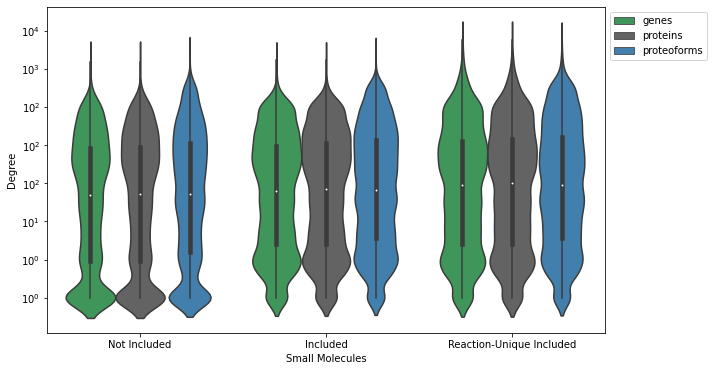

In [71]:
from matplotlib import ticker as mticker

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
fig.set_size_inches(10, 6)
fig5 = sns.violinplot(x="Small Molecules", y="Degree", hue="Entity Level", data=df_seq, palette=config.COLORS_BORDER)
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))  # Convert ticks to powers of 10
plt.legend(bbox_to_anchor=(1.0, 1), borderaxespad=0.5)  # Put the legend out of the figure
plt.show()
fig5.figure.savefig('figures/figure_5.png')

In [72]:
from pathlib import Path
from config import METHODS, PATHWAY_GRAPHS_PATH
from config import LEVELS
from lib.networks import get_json_filename, create_pathway_interaction_network, read_graph, \
    get_pathways_with_multiple_proteoforms
from lib.graph_database_access import get_pathways

columns = [
    'Pathway',
    'Small Molecules',
    'Increase Nodes Genes-Proteins',
    'Increase Interactions Genes-Proteins',
    'Increase Nodes Proteins-Proteoforms',
    'Increase Interactions Proteins-Proteoforms'
]


def get_pathway_tuples(pathway, graphs):
    increase_nodes_genes_proteins = get_increase_percentage(graphs[genes].number_of_nodes(),
                                                            graphs[proteins].number_of_nodes())
    increase_links_genes_proteins = get_increase_percentage(graphs[genes].number_of_edges(),
                                                            graphs[proteins].number_of_edges())
    increase_nodes_proteins_proteoforms = get_increase_percentage(graphs[proteins].number_of_nodes(),
                                                                  graphs[proteoforms].number_of_nodes())
    increase_links_proteins_proteoforms = get_increase_percentage(graphs[proteoforms].number_of_edges(),
                                                                  graphs[proteoforms].number_of_edges())

    return (
        pathway,
        graphs[genes].graph["method"],
        increase_nodes_genes_proteins,
        increase_links_genes_proteins,
        increase_nodes_proteins_proteoforms,
        increase_links_proteins_proteoforms
    )


data_pathways = []
# pathways = get_pathways()["stId"]
pathways = get_pathways_with_multiple_proteoforms(interactome_networks_path, pathway_networks_path)
for pathway in pathways:
    for method in METHODS:
        pathway_graphs = {}
        for level in LEVELS:
            filename = get_json_filename(level, method, PATHWAY_GRAPHS_PATH, pathway)
            if not Path(filename).exists():
                create_pathway_interaction_network(pathway, level, method, PATHWAY_GRAPHS_PATH)
            G = read_graph(filename)
            pathway_graphs[level] = G
        if pathway_graphs[genes].number_of_nodes() > 0\
                and pathway_graphs[genes].number_of_edges() > 0\
                and pathway_graphs[genes].number_of_nodes() < 20:
            data_pathways.append(get_pathway_tuples(pathway, pathway_graphs))

df_pathways = pd.DataFrame.from_records(data_pathways, columns=columns)
df_pathways

    * Creating network networks\pathways\R-HSA-9615933_genes_no_sm.json
    * Creating network networks\pathways\R-HSA-9615933_proteins_no_sm.json
    * Creating network networks\pathways\R-HSA-9615933_proteoforms_no_sm.json
    * Creating network networks\pathways\R-HSA-9615933_genes_with_sm.json
    * Creating network networks\pathways\R-HSA-9615933_proteins_with_sm.json
    * Creating network networks\pathways\R-HSA-9615933_proteoforms_with_sm.json
    * Creating network networks\pathways\R-HSA-9615933_genes_with_unique_sm.json
    * Creating network networks\pathways\R-HSA-9615933_proteins_with_unique_sm.json
    * Creating network networks\pathways\R-HSA-9615933_proteoforms_with_unique_sm.json
    * Creating network networks\pathways\R-HSA-2467813_genes_no_sm.json
    * Creating network networks\pathways\R-HSA-2467813_proteins_no_sm.json
    * Creating network networks\pathways\R-HSA-2467813_proteoforms_no_sm.json
    * Creating network networks\pathways\R-HSA-2467813_genes_with_s

In [ ]:
from bokeh.io import show
from visualization.visualize_single_network import Coloring, plot_pathway_all_levels
from lib.networks import create_pathway_interaction_networks

# Example nodes genes-proteins
df_pathways.sort_values(by=['Increase Nodes Genes-Proteins'], ascending=False, inplace=True)
examples = df_pathways.head(20)["Pathway"].unique()
print(examples)

for example in examples:
    graphs = create_pathway_interaction_networks(example, "resources/pathway_networks/")
    p = plot_pathway_all_levels(example, out_path="resources/pathway_networks/", graphs=graphs,
                                coloring=Coloring.ENTITY_TYPE, outline_line_width=1,
                                node_size = 12,
                                inner_plot_size=350,
                                highlight_articulations=True,
                                highlight_bridges=True,
                                toolbar_location='below')
    show(p)
df_pathways.head(20)

In [ ]:
df_pathways.sort_values(by=['Increase Nodes Proteins-Proteoforms'], ascending=False, inplace=True)
examples = df_pathways.head(10)["Pathway"].unique()
print(examples)
df_pathways[["Pathway", "Increase Nodes Proteins-Proteoforms", "Increase Interactions Proteins-Proteoforms"]].head(20)

In [ ]:
df_pathways.sort_values(by=['Increase Interactions Proteins-Proteoforms'], ascending=False, inplace=True)
df_pathways[["Pathway", "Increase Nodes Proteins-Proteoforms", "Increase Interactions Proteins-Proteoforms"]].head(12)

In [ ]:
combinations = get_combinations()
columns = [
    "Small Molecules",
    "Entity Level",
    "Min. Degree Accessioned Entities",
    "Avg. Degree Accessioned Entities",
    "Max. Degree Accessioned Entities",
    "Min. Degree Small Molecules",
    "Avg. Degree Small Molecules",
    "Max. Degree Small Molecules"
]

def get_tuples(G):

    acc_ents = list(G.nodes)
    sm_ents = []
    if G.graph['num_small_molecules'] > 0:
        acc_ents = [n for n in G.nodes if not G.nodes[n]['type'].startswith("Simple")]
        sm_ents = [n for n in G.nodes if G.nodes[n]['type'].startswith("Simple")]

    deg_seq_acc_ents = [d for n, d in list(G.degree(acc_ents))]

    min_deg_sm_ents = 0
    avg_deg_sm_ents = 0
    max_deg_sm_ents = 0
    if len(sm_ents) > 0:
        deg_seq_sm_ents = [d for n, d in list(G.degree(sm_ents))]
        min_deg_sm_ents = min(deg_seq_sm_ents)
        avg_deg_sm_ents = mean(deg_seq_sm_ents)
        max_deg_sm_ents = max(deg_seq_sm_ents)

    return (
        G.graph["method"], G.graph["level"],
        min(deg_seq_acc_ents), mean(deg_seq_acc_ents), max(deg_seq_acc_ents),
        min_deg_sm_ents, avg_deg_sm_ents, max_deg_sm_ents
    )

In [ ]:
df_deg_interactomes = pd.DataFrame([get_tuples(I) for I in interactomes], columns=columns, index=index)
df_deg_interactomes.drop(["Small Molecules","Entity Level"], axis=1)

In [ ]:
for method in config.SMALL_MOLECULES:
    print(f"Small Molecules: {method}")
    avg_genes = df_deg_interactomes.loc[method,'genes']["Avg. Degree Accessioned Entities"]
    avg_proteins = df_deg_interactomes.loc[method,'proteins']["Avg. Degree Accessioned Entities"]
    avg_proteoforms = df_deg_interactomes.loc[method,'proteoforms']["Avg. Degree Accessioned Entities"]
    inc_genes_proteins = get_increase_percentage(avg_genes, avg_proteins)
    inc_proteins_proteoforms = get_increase_percentage(avg_proteins, avg_proteoforms)
    print(f"There is an increase of degree: {inc_genes_proteins}% from genes to proteins")
    print(f"There is an increase of degree: {inc_proteins_proteoforms}% from proteins to proteoforms")


In [ ]:
combinations = get_combinations_with_pathways(3)

columns = [
    "Small Molecules",
    "Entity Level",
    "Pathway",
    "Min. Degree Accessioned Entities",
    "Avg. Degree Accessioned Entities",
    "Max. Degree Accessioned Entities",
    "Min. Degree Small Molecules",
    "Avg. Degree Small Molecules",
    "Max. Degree Small Molecules"
]

out_path = "resources/pathway_networks/"

def get_tuples(combination):
    G = create_pathway_interaction_network(
        method=combination[0], level=combination[1], pathway=combination[2], out_path=out_path
    )

    acc_ents = list(G.nodes)
    sm_ents = []
    if G.graph['num_small_molecules'] > 0:
        acc_ents = [n for n in G.nodes if not G.nodes[n]['type'].startswith("Simple")]
        sm_ents = [n for n in G.nodes if G.nodes[n]['type'].startswith("Simple")]

    deg_seq_acc_ents = [d for n, d in list(G.degree(acc_ents))]
    min_deg_sm_ents = 0
    avg_deg_sm_ents = 0
    max_deg_sm_ents = 0
    if len(sm_ents) > 0:
        deg_seq_sm_ents = [d for n, d in list(G.degree(sm_ents))]
        min_deg_sm_ents = min(deg_seq_sm_ents)
        avg_deg_sm_ents = mean(deg_seq_sm_ents)
        max_deg_sm_ents = max(deg_seq_sm_ents)

    return (
        combination[0], combination[1], combination[2],
        min(deg_seq_acc_ents), mean(deg_seq_acc_ents), max(deg_seq_acc_ents),
        min_deg_sm_ents, avg_deg_sm_ents, max_deg_sm_ents
    )

In [ ]:
df_deg_pathways = pd.DataFrame([get_tuples(combination) for combination in combinations], columns=columns)
df_deg_pathways

In [ ]:
df_deg_pathways_agg = df_deg_pathways.groupby(['Small Molecules', 'Entity Level']).agg(
    {
        "Min. Degree Accessioned Entities": ['mean'],
        "Avg. Degree Accessioned Entities": ['mean'],
        "Max. Degree Accessioned Entities": ['mean'],
        "Min. Degree Small Molecules": ['mean'],
        "Avg. Degree Small Molecules": ['mean'],
        "Max. Degree Small Molecules": ['mean']
    })
df_deg_pathways_agg.columns = [
    "Min. Degree Accessioned Entities",
    "Avg. Degree Accessioned Entities",
    "Max. Degree Accessioned Entities",
    "Min. Degree Small Molecules",
    "Avg. Degree Small Molecules",
    "Max. Degree Small Molecules"
]
df_pathways_grouped = df_deg_pathways_agg.set_index(get_multiindex())
df_pathways_grouped

In [ ]:
import matplotlib.pyplot as plt

sns.set(rc = {"figure.facecolor": "white"})

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
fig.set_size_inches(10, 6)
f = sns.violinplot(x="Small Molecules", y="Avg. Degree Accessioned Entities", hue="Entity Level",
                   data=df_deg_pathways, palette=config.COLORS_BORDER)
#ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$")) # Convert ticks to powers of 10
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.set_title("Distribution of Avg. Degree of Accessioned Entities in all Pathways")

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
fig.set_size_inches(10, 6)
f = sns.violinplot(x="Small Molecules", y="Avg. Degree Small Molecules", hue="Entity Level",
                   data=df_deg_pathways, palette=config.COLORS_BORDER)
#ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$")) # Convert ticks to powers of 10
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.set_title("Distribution of Avg. Degree of Small Molecules in all Pathways")

In [ ]:
df_deg_pathways[
    (df_deg_pathways["Small Molecules"] == 'with_unique_sm') & (df_deg_pathways["Entity Level"] == 'proteoforms')]

In [ ]:
df_pathways_grouped.reset_index(inplace=True)
df_pathways_grouped

In [ ]:
df_interactomes_temp = df_deg_interactomes[["Avg. Degree Accessioned Entities",
    "Avg. Degree Small Molecules"]]
df_interactomes_temp.reset_index(inplace=True)
df_interactomes_temp

In [ ]:
df_degrees = pd.concat([df_interactomes_temp, df_pathways_grouped[["Avg. Degree Accessioned Entities",
    "Avg. Degree Small Molecules"]]], axis=1)
df_degrees.set_index(index, inplace=True)
df_degrees.drop(df_degrees.columns[[0,1]],axis=1,inplace=True)
df_degrees